Используя базу "Аудиожанры", примените подход к музыке как к тексту и напишите сверточный классификатор (на базе слоя Conv1D) для подготовленных данных. Для этого:

1. Измените подготовку данных так, чтобы набор признаков, извлекаемый из аудиофайла, был представлен в виде последовательностей векторов признаков. Последовательности должны быть фиксированного размера и выбираться скользящим окном c заданным шагом. Другими словами: берем аудио-файл длительность, например, 30 сек. Берем отрезок фиксированной длины (например, 5с) и получаем набор признаков для этого отрезка. Смещаемся на шаг (например, 1с) и берем следующий отрезок. Таким образом готовим обучающую вборку.
2. Длину последовательности, размер шага и достаточный набор признаков определите самостоятельно исходя из требований к точности классификатора;
3. Разработайте классификатор на одномерных сверточных слоях **Conv1D** с точностью классификации жанра на тестовых данных не ниже **60%**, а на обучающих файлах - **68%** и выше;
4. Используйте за основу материал с урока, но при желании разработайте свои инструменты.

Импортируем необходимые библиотеки:

In [1]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os

# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, SpatialDropout1D

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Загрузим датасет в Colab:

In [2]:
# Загрузка датасета из облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l12/genres.zip', None, quiet=True)

'genres.zip'

In [3]:
# Распаковка архива на локальный диск colab
!unzip -qo genres.zip

# Проверка выгруженных папок
!ls genres

# Проверка содержимого одной папки
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [4]:
# Параметры
WINDOW_SIZE = 5       # длина окна в секундах
STEP_SIZE = 1         # шаг окна в секундах
SR = 22050            # частота дискретизации
N_MFCC = 13           # число MFCC признаков

In [5]:
# Вычисление параметров окна и шага
samples_per_window = WINDOW_SIZE * SR
step_samples = STEP_SIZE * SR

X = []  # Список для хранения признаков (MFCC)
y = []  # Список для хранения меток (жанров)

# Путь к папке с жанрами
genres_path = 'genres'
genres = os.listdir(genres_path)

# Проходим по каждому жанру и каждому аудиофайлу в жанре
for genre in genres:
    genre_path = os.path.join(genres_path, genre)
    for file in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file)
        audio, sr = librosa.load(file_path, sr=SR)

        for start in range(0, len(audio) - samples_per_window, step_samples):
          window = audio[start:start + samples_per_window]
          mfcc = librosa.feature.mfcc(y=window, sr=sr, n_mfcc=N_MFCC)
          mfcc = mfcc.T
          if mfcc.shape[0] == 216:
              X.append(mfcc)
              y.append(genre)

# Преобразуем списки в numpy-массивы
X = np.array(X)
y = np.array(y)

# Выводим размеры массивов признаков и меток
print("Признаки:", X.shape)
print("Метки:", y.shape)


Признаки: (25990, 216, 13)
Метки: (25990,)


In [6]:
# Кодировка меток жанров
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Масштабирование признаков
scaler = StandardScaler()
n_samples, n_frames, n_features = X.shape
X_reshaped = X.reshape(-1, n_features)
X_scaled = scaler.fit_transform(X_reshaped).reshape(n_samples, n_frames, n_features)


In [7]:
# Разделение данных на обучающую и тестовую выборки:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=42, stratify=y_cat)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (20792, 216, 13)
Test shape: (5198, 216, 13)


In [18]:
# Создаём последовательную модель
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    # Полносвязный слой: 128 нейронов
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

# Компиляция модели: функция потерь — кросс-энтропия, оптимизатор — Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 214, 64)        │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 214, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 107, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 107, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 105, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 105, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 52, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 52, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6656)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       852,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 881,418 (3.36 MB)

 Trainable params: 881,034 (3.36 MB)

 Non-trainable params: 384 (1.50 KB)

In [19]:
# Обучение модели
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=200,
                    batch_size=32,
                    verbose=1)


Epoch 1/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.4909 - loss: 1.6236 - val_accuracy: 0.7145 - val_loss: 0.8781
Epoch 2/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6966 - loss: 0.8669 - val_accuracy: 0.7586 - val_loss: 0.7974
Epoch 3/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7639 - loss: 0.6576 - val_accuracy: 0.7645 - val_loss: 0.7765
Epoch 4/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8134 - loss: 0.5355 - val_accuracy: 0.7997 - val_loss: 0.6580
Epoch 5/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8359 - loss: 0.4709 - val_accuracy: 0.8097 - val_loss: 0.6545
Epoch 6/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8638 - loss: 0.3914 - val_accuracy: 0.8355 - val_loss: 0.5587
Epoch 7/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8821 - loss: 0.3462 - val_accuracy: 0.8505 - val_loss: 0.5357
Epoch 8/200
650/650 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8961 - loss: 0.3021 - val_ac

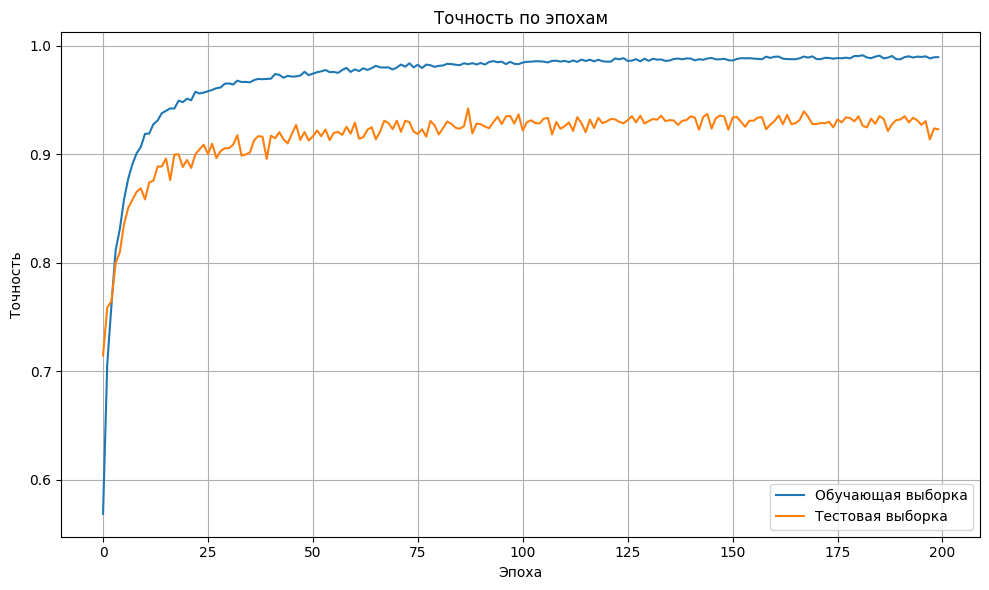

In [20]:
import matplotlib.pyplot as plt

# График точности обучения и валидации по эпохам
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Обучающая выборка')
plt.plot(history.history['val_accuracy'], label='Тестовая выборка')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# Точность
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Точность на обучающей выборке: {train_acc:.2%}")
print(f"Точность на тестовой выборке: {val_acc:.2%}")

Точность на обучающей выборке: 98.96%
Точность на тестовой выборке: 92.30%


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


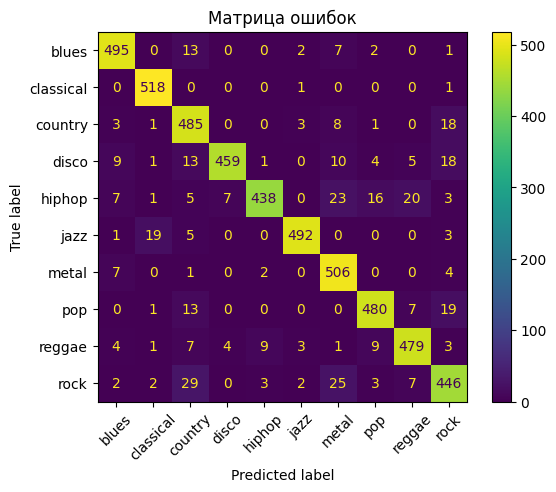

In [22]:
# Матрица ошибок
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=45)
plt.title("Матрица ошибок")
plt.show()